Found 10742 images in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/images/train
Found 10742 labels in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/labels/train
Found 1144 images in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/images/val
Found 1144 labels in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/labels/val
Found 3749 images in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/images/test
Found 3749 labels in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/labels/test


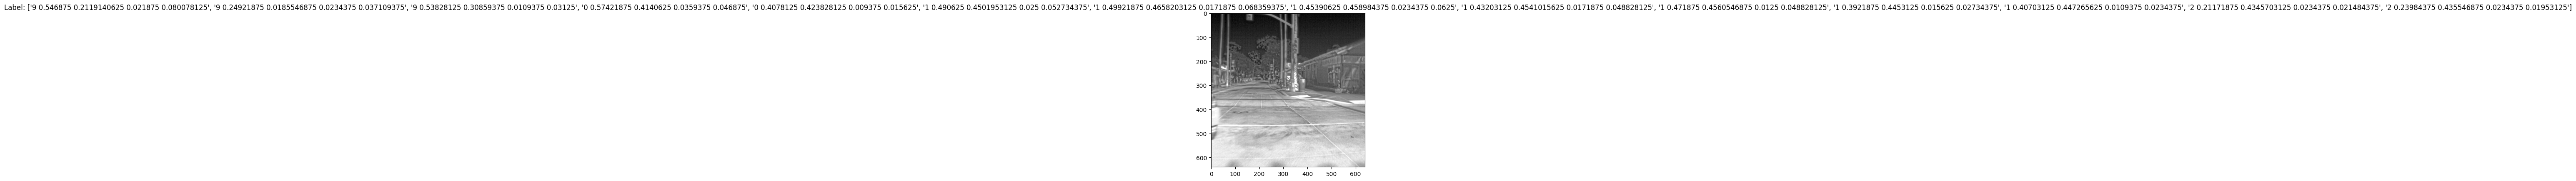

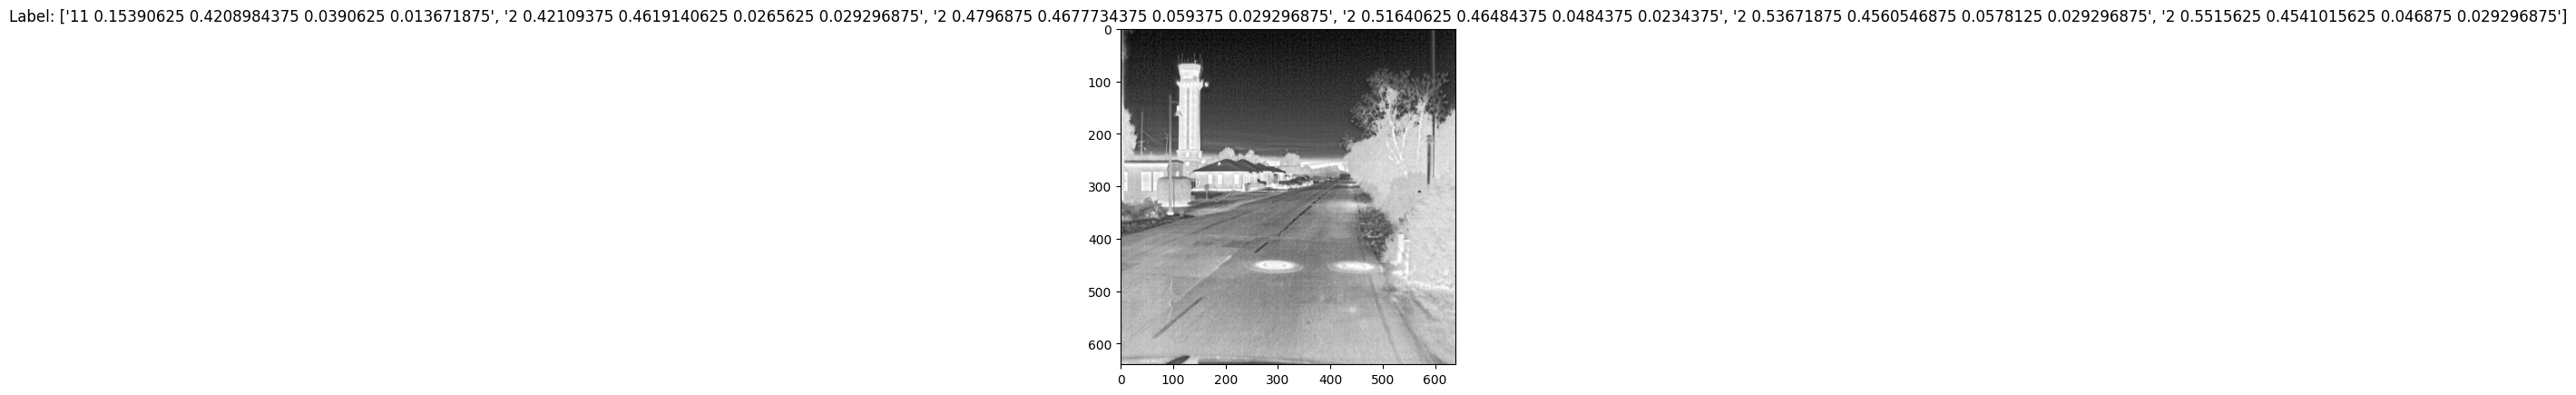

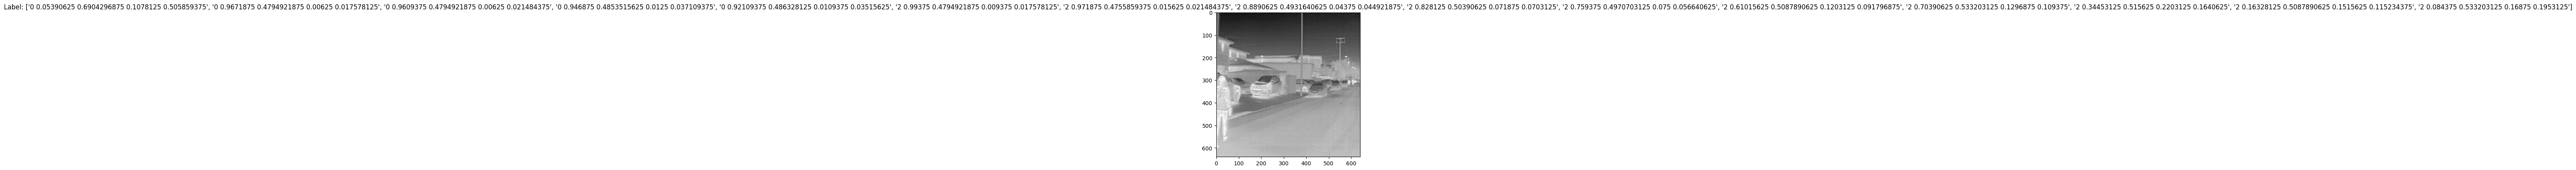

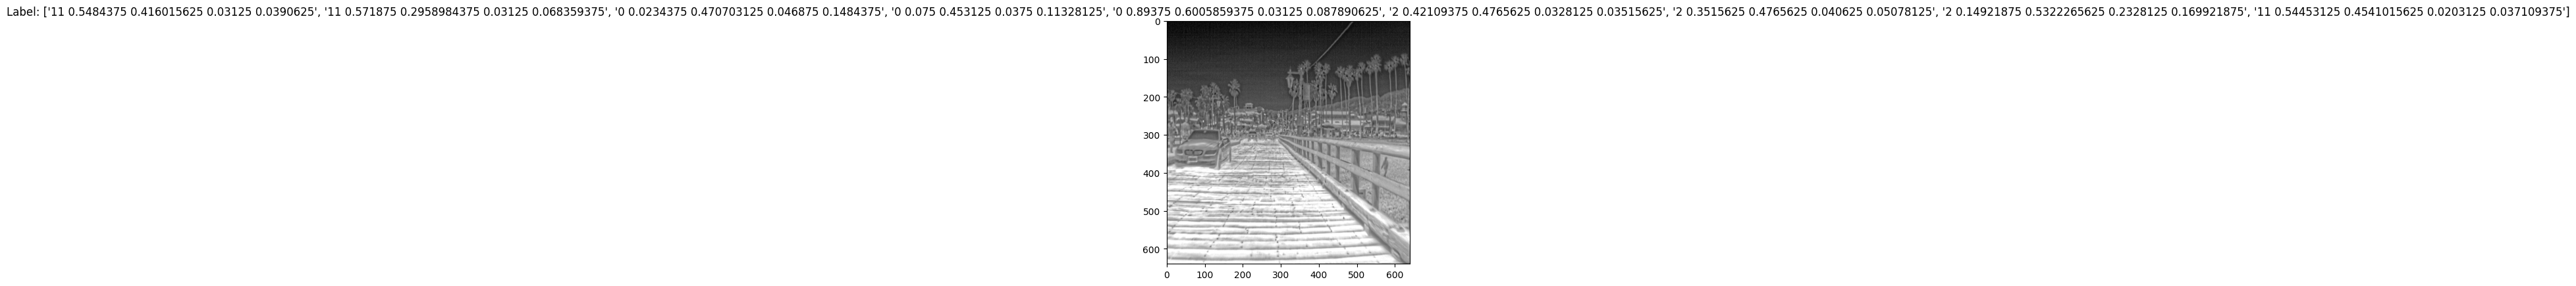

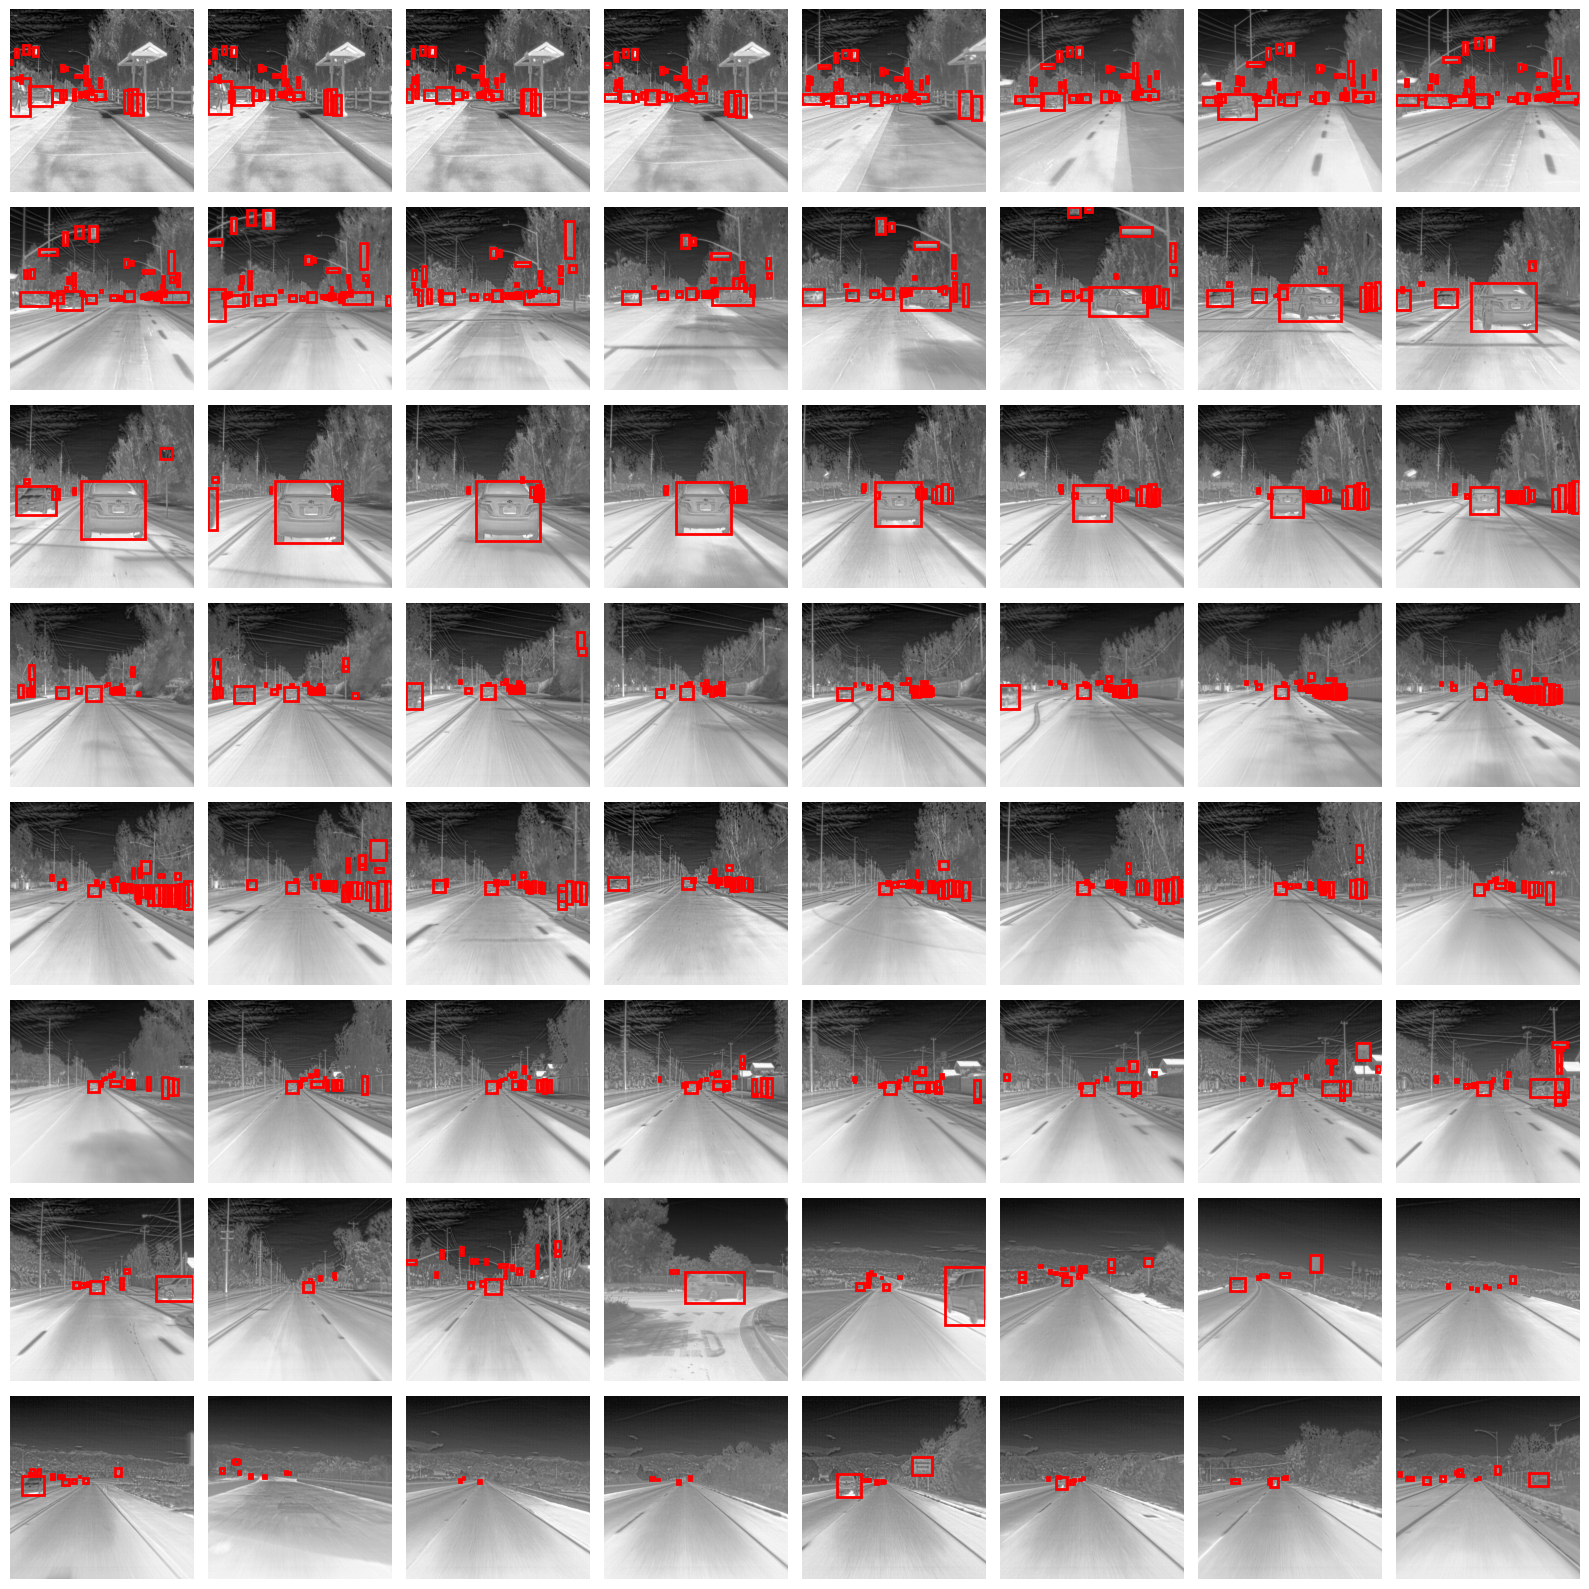

In [9]:
### Cell 1: Import Necessary Libraries
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

### Cell 2: Define Utility Functions

def convert_to_single_channel(img):
    """
    Converts a 3-channel image (RGB/BGR) to a single channel (grayscale).

    Args:
        img (np.ndarray): Input image, shape (H, W, 3).

    Returns:
        np.ndarray: Single-channel image, shape (H, W).
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.astype(np.float32) / 255.0  # Normalize to range [0, 1]
    return img_gray

### Cell 3: Define YOLO Dataset Class

class YoloThermalDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_size=(640, 640)):
        """
        Initialize the YOLO dataset for thermal images.

        Args:
            image_dir (str): Path to the directory containing images.
            label_dir (str): Path to the directory containing labels.
            transform (callable, optional): Transform to apply to images and labels.
            target_size (tuple): Target size to resize images (height, width).
        """
        self.image_paths = sorted(Path(image_dir).glob("*.jpg"))
        self.label_paths = sorted(Path(label_dir).glob("*.txt"))
        self.transform = transform
        self.target_size = target_size  # Target size for resizing

        # Check for mismatches and missing data
        if not self.image_paths:
            raise FileNotFoundError(f"No images found in {image_dir}")
        if not self.label_paths:
            raise FileNotFoundError(f"No labels found in {label_dir}")
        
        # Filter label paths to match image paths
        self.image_paths, self.label_paths = self._filter_matching_files(self.image_paths, self.label_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        img = cv2.imread(str(img_path))
        img = convert_to_single_channel(img)  # Convert to single-channel

        # Resize the image to the target size
        img = cv2.resize(img, self.target_size)

        # Add a channel dimension to the grayscale image
        img = np.expand_dims(img, axis=0)  # Shape: (1, H, W)

        # Convert image to a torch tensor
        img = torch.tensor(img, dtype=torch.float32)

        # Load label
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f.readlines()]

        return img, labels

    @staticmethod
    def _filter_matching_files(image_paths, label_paths):
        """
        Ensures each image has a corresponding label file by matching base filenames.

        Args:
            image_paths (list): List of image paths.
            label_paths (list): List of label paths.

        Returns:
            Tuple[list, list]: Filtered image and label paths.
        """
        image_basenames = {p.stem for p in image_paths}
        label_basenames = {p.stem for p in label_paths}
        common_basenames = image_basenames & label_basenames

        filtered_images = [p for p in image_paths if p.stem in common_basenames]
        filtered_labels = [p for p in label_paths if p.stem in common_basenames]

        if len(filtered_images) != len(filtered_labels):
            print(f"Warning: Mismatch after filtering. {len(filtered_images)} images and {len(filtered_labels)} labels.")

        return filtered_images, filtered_labels

### Cell 4: Instantiate Datasets and DataLoaders

# Dataset paths
base_dir = os.path.expanduser("~/projects/YOLO-RGB-T/notebooks/FLIR/T")
image_dir = os.path.join(base_dir, "images")
label_dir = os.path.join(base_dir, "labels")

# Verify dataset directories and content
def check_dataset_paths(image_dir, label_dir):
    """Utility to check if dataset paths and files are valid."""
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(label_dir):
        raise FileNotFoundError(f"Label directory not found: {label_dir}")
    print(f"Found {len(list(Path(image_dir).glob('*.jpg')))} images in {image_dir}")
    print(f"Found {len(list(Path(label_dir).glob('*.txt')))} labels in {label_dir}")

check_dataset_paths(os.path.join(image_dir, "train"), os.path.join(label_dir, "train"))
check_dataset_paths(os.path.join(image_dir, "val"), os.path.join(label_dir, "val"))
check_dataset_paths(os.path.join(image_dir, "test"), os.path.join(label_dir, "test"))

train_dataset = YoloThermalDataset(
    image_dir=os.path.join(image_dir, "train"),
    label_dir=os.path.join(label_dir, "train"),
    target_size=(640, 640)  # Resize all images to 640x640
)

val_dataset = YoloThermalDataset(
    image_dir=os.path.join(image_dir, "val"),
    label_dir=os.path.join(label_dir, "val"),
    target_size=(640, 640)
)

test_dataset = YoloThermalDataset(
    image_dir=os.path.join(image_dir, "test"),
    label_dir=os.path.join(label_dir, "test"),
    target_size=(640, 640)
)

# Define a custom collate function
def custom_collate_fn(batch):
    """
    Custom collate function to handle variable-length labels.
    Args:
        batch: A list of (image, label) tuples.
    Returns:
        images: A tensor batch of images.
        labels: A list of labels.
    """
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)  # Stack images into a tensor
    return images, labels

# DataLoaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)

### Cell 5: Test the DataLoader

for imgs, labels in train_loader:
    for img, label in zip(imgs, labels):
        plt.imshow(img[0].numpy(), cmap='gray')  # img[0] removes channel dimension for display
        plt.title(f"Label: {label}")
        plt.show()
    break  # Display one batch

### Cell 6: Plot Bounding Boxes in an 8x8 Matrix

def plot_bboxes(dataset, num_images=64):
    """
    Plot bounding boxes from the dataset in an 8x8 grid.

    Args:
        dataset (Dataset): The dataset to visualize.
        num_images (int): Total number of images to display (default: 64).
    """
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    axes = axes.flatten()

    for i in range(min(num_images, len(dataset))):
        img, labels = dataset[i]
        img = img.squeeze(0).numpy()  # Remove channel dimension

        # Plot the image
        ax = axes[i]
        ax.imshow(img, cmap='gray')

        # Plot bounding boxes
        for label in labels:
            bbox = list(map(float, label.split()[1:]))  # YOLO format: class x_center y_center width height
            x_center, y_center, width, height = bbox

            # Convert from relative to absolute coordinates
            x_center *= img.shape[1]
            y_center *= img.shape[0]
            width *= img.shape[1]
            height *= img.shape[0]

            # Calculate box corners
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2

            # Draw the rectangle
            rect = plt.Rectangle((x1, y1), width, height, edgecolor='red', facecolor='none', lw=2)
            ax.add_patch(rect)

        ax.axis('off')

    # Hide remaining axes if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Test the plot_bboxes function
plot_bboxes(train_dataset)


In [ ]:
### Cell 1: Import Necessary Libraries
import torch
import torch.nn as nn
import yaml
from ultralytics import *
from ultralytics.nn.modules import Concat  # Ensure Concat is imported

### Cell 2: Define the YOLOv11 Model

def autopad(k, p=None):
    """Pad to 'same' shape outputs."""
    return k // 2 if p is None else p

class YOLOv11(nn.Module):
    def __init__(self, scale='s', num_classes=80):
        """
        Initialize the YOLOv11 model.

        Args:
            scale (str): Model scale, one of ['n', 's', 'm', 'l', 'x'].
            num_classes (int): Number of output classes.
        """
        super().__init__()
        self.scale = scale
        self.num_classes = num_classes

        # Define depth and width multipliers for each scale
        scales = {
            'n': {'depth': 0.50, 'width': 0.25, 'max_channels': 1024},
            's': {'depth': 0.50, 'width': 0.50, 'max_channels': 1024},
            'm': {'depth': 0.50, 'width': 1.00, 'max_channels': 512},
            'l': {'depth': 1.00, 'width': 1.00, 'max_channels': 512},
            'x': {'depth': 1.00, 'width': 1.50, 'max_channels': 512},
        }

        assert scale in scales, f"Invalid scale '{scale}', choose from ['n', 's', 'm', 'l', 'x']"
        multiplier = scales[scale]

        d, w = multiplier['depth'], multiplier['width']

        # Define model layers based on YAML file
        with open('/home/dylan/projects/YOLO-RGB-T/YOLOv11-T.yaml', 'r') as f:
            model_config = yaml.safe_load(f)

        self.layers = self._build_model(model_config, d, w, num_classes)

    def _build_model(self, config, depth_mult, width_mult, num_classes):
        """
        Build the model layers based on the configuration.

        Args:
            config (dict): YAML configuration for the model.
            depth_mult (float): Depth multiplier.
            width_mult (float): Width multiplier.
            num_classes (int): Number of classes.

        Returns:
            nn.Sequential: Constructed model layers.
        """
        layers = []
        for layer_cfg in config['backbone'] + config['head']:
            from_layer, repeats, module, args = layer_cfg

            if module == 'Conv':
                if len(args) == 3:
                    c1, c2, k = args
                    s = 1  # Default stride if not provided
                else:
                    c1, c2, k, s = args
                c1 = max(1, int(c1 * width_mult))
                c2 = max(1, int(c2 * width_mult))
                layers.append(Conv(c1, c2, k, s))

            elif module == 'C3k2':
                c1, c2 = args[:2]  # Ensure at least c1 and c2 are extracted
                shortcut = args[2] if len(args) > 2 else False  # Default shortcut to False
                e = args[3] if len(args) > 3 else 0.5  # Default expansion to 0.5
                c1 = max(1, int(c1 * width_mult))
                c2 = max(1, int(c2 * width_mult))
                repeats = max(1, int(repeats * depth_mult))
                layers.append(C3k2(c1, c2, repeats, shortcut, e))

            elif module == 'SPPF':
                if len(args) == 2:
                    c1, c2 = args
                    k = 5  # Default kernel size if not provided
                else:
                    c1, c2, k = args
                c1 = max(1, int(c1 * width_mult))
                c2 = max(1, int(c2 * width_mult))
                layers.append(SPPF(c1, c2, k))

            elif module == 'C2PSA':
                c1 = max(1, int(args[0] * width_mult))
                layers.append(C2PSA(c1, c1))

            elif module == 'Concat':
                dimension = args[0]
                layers.append(Concat(dimension))

            elif module == 'nn.Upsample':
                scale_factor, mode = args[1], args[2]
                layers.append(nn.Upsample(scale_factor=scale_factor, mode=mode))

            elif module == 'Detect':
                if isinstance(args[0], list):  # Multiple inputs, e.g., P3, P4, P5
                    inputs = [max(1, int(c * width_mult)) for c in args[0]]
                    c1 = sum(inputs)  # Combine inputs for the detection head
                else:
                    pnt(ori)
                    print(args[0])
                    if isinstance(args[0], (int, float)):
                        c1 = max(1, int(args[0] * width_mult))
                    else:
                        raise TypeError(f"Invalid type for args[0]: {type(args[0])}. Expected numeric or list.")
                layers.append(nn.Conv2d(c1, num_classes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass of the YOLOv11 model."""
        for layer in self.layers:
            x = layer(x)
        return x

### Cell 3: Instantiate and Test the Model

def test_model():
    """Test the YOLOv11 model with a dummy input."""
    model = YOLOv11(scale='s', num_classes=80)
    x = torch.randn(1, 1, 640, 640)  # Dummy single-channel input
    y = model(x)
    print(f"Output shape: {y.shape}")

if __name__ == '__main__':
    test_model()


TypeError: Invalid type for args[0]: <class 'str'>. Expected numeric or list.